0.6822498292215641
0.4466698157104269
IRR: [0, -1.2497849403504921, nan, nan, nan, nan, nan, nan, nan, 0.14514289885195875, 0.1416489686607183, 0.13974467932031187, nan, nan, -0.11755034078220195, -0.0014175957067651401, 0.04028072710993791, 0.06429346182960649, 0.13341407608360956, 0.1331280486512041, 0.13268241193806984]
ROI: [-1.0, -1.2497849403504921, -1.4362016504578863, -1.5581554413892984, -1.6143854920473273, -1.603458173696276, -1.5237598405710235, -1.3734890582471986, -1.1506482395580613, 2.386391449905305, 2.761195316587678, 3.215832116799576, -2.161957265276648, -1.5387699500464715, -0.8263562500271271, -0.021054220649181648, 0.881086821356215, 1.8843217268634638, 8.527848318284315, 9.747335539715966, 11.082676239478202]
B_cumNPV: [  0.44666982  18.24180422  35.40688768  51.96434108  67.93579441
  83.3421151   98.20343532 112.53917841 126.3680843  140.4713782
 153.34021809 165.75458194 177.73071366 189.28428847 200.43043357
 211.18374806 221.5583222  231.56775599 242.529023

C:\Users\edwar\AppData\Local\Temp\ipykernel_81540\1046211409.py:1707: RuntimeWarning: invalid value encountered in double_scalars
  IRR.append((1+ROI[i])**(1/i)-1)
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\edwar\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\edwar\AppData\Local\Temp\ipykernel_81540\1046211409.py", line 1765, in calculate_irr
    for i in range(1, SimulationDuration):
TypeError: 'float' object cannot be interpreted as an integer


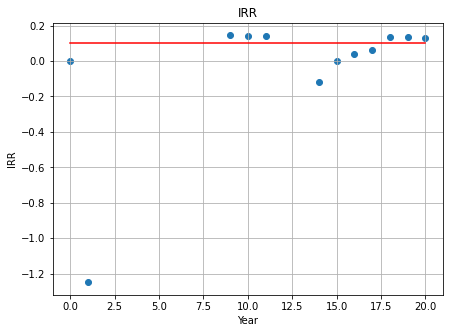

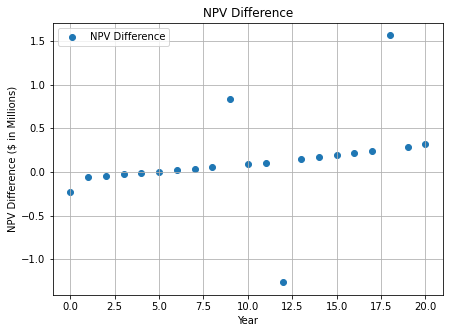

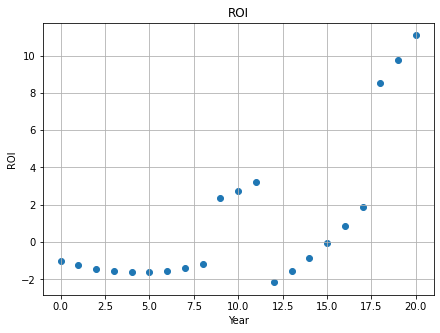

In [6]:
import tkinter as tk
from tkinter import filedialog
from tkinter import ttk
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
from tkinter import OptionMenu
from tkinter import messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import os

class FileInputGUI(tk.Frame):
    def __init__(self, root):
        super().__init__(root)
        self.root = root
        self.settings_window = None
        self.settings_entries = {}
        
        self.input_reference = {}
        self.input_interest = {}
        
        self.elements_window = None
        self.canvas_ROI = None
        self.canvas_IRR = None
        self.canvas_NPV = None
        self.popup = None
        self.output_box_2 = tk.Text(self.root)
        self.tree_2 = ttk.Treeview(self.root)
        self.root.title("Cost Model Demonstration V1.0")
        
        self.add_file_option = tk.StringVar()
        self.add_file_option.set("Add second HTM/SQL file")
        
        # Create a canvas widget
        self.canvas = tk.Canvas(root)
        self.canvas.grid(row=0, column=0, sticky="nsew")

        # Add scrollbars to the canvas
        self.v_scrollbar = tk.Scrollbar(root, orient="vertical", command=self.canvas.yview)
        self.v_scrollbar.grid(row=0, column=1, sticky="ns")
        self.h_scrollbar = tk.Scrollbar(root, orient="horizontal", command=self.canvas.xview)
        self.h_scrollbar.grid(row=1, column=0, sticky="ew")
        
        self.canvas.configure(yscrollcommand=self.v_scrollbar.set, xscrollcommand=self.h_scrollbar.set)

        # Create a frame inside the canvas to hold all widgets
        self.scrollable_frame = tk.Frame(self.canvas)
        self.canvas.create_window((0, 0), window=self.scrollable_frame, anchor='nw')
        
        # Configure the scroll region
        self.scrollable_frame.bind("<Configure>", lambda e: self.canvas.configure(scrollregion=self.canvas.bbox("all")))
        
        # Make the grid cells expandable
        root.grid_rowconfigure(0, weight=1)
        root.grid_columnconfigure(0, weight=1)
        self.scrollable_frame.grid_rowconfigure(0, weight=1)
        self.scrollable_frame.grid_columnconfigure(0, weight=1)
        
        self.create_widgets()
        
        # Initialize cooling cost variables
        self.cooling_cost1 = 0
        self.cooling_cost2 = 0
        
        total_equipment_cost = 0
        
        # Define a custom font
        custom_font = ("Times New Roman", 14)

        # Apply the custom font to all widgets
        root.option_add("*Font", custom_font)
        
        # Check if cooling costs are valid
        if self.cooling_cost1 < self.cooling_cost2:
            tk.messagebox.showerror("Error", "Cooling cost in Default Case is less than Cooling cost in Case of Interest! This will not produce an IRR graph")
            return

        # Add textboxes with prefilled variables
        self.variables = {
            "Duration of Simulation (years)":"20",
            "Electricity Cost ($/kWh)": "0.145",
            "Cooling Maintenance Cost (per event)": "50000",
            "Energy Inflation (per year)": "0.0224",
            "Inflation (per year)": "0.035",
            "Discount Rate (per year)": "0.06",
            "IT Maintenance Cost (per event)": "250000",
            "Cost of Cooling Fluid ($/thousand gallons)":"10.65",
            "Data Center Capacity (kW)": "1000",
            "CEPCI Number":"8.008",
            "Reference Cooling System MTBF (hours)":"2000",
            "Analysis Cooling System MTBF (hours)":"3000",
            "IT MTBF for the Reference Cooling System (hours)":"5000",
            "IT MTBF for the Analysis Cooling System (hours)":"6000",
            "Recovered Heat (fraction of energy cost)": "0.1",
            "Piping Size (Diameter in.)":"4",
            "Duct Size (sq ft)":"4"
        }
        
        self.elements = {
            "IT_Electrically_Active_Floor_Space" : "0",
            "IT_Equipment_reliability" : "0",
            "Number of Servers" : "0",
            "IT Redundancy" : "0",
            "IT Energy Cost Increase" : "0",
            "Non Server IT Hardware" : "0"
        }
        
        # Input labels
        self.input_label1 = tk.Label(self.scrollable_frame, text="Parameters from E+")
        self.input_label1.grid(row=3, column=0, columnspan=3, sticky='w')

        self.input_label2 = tk.Label(self.scrollable_frame, text="Cost of Cooling System and its Components")
        self.input_label2.grid(row=3, column=4, columnspan=3, sticky='w')

        # First file input widgets
        self.label1 = tk.Label(self.scrollable_frame, text="Add the first HTM/SQL file:")
        self.label1.grid(row=1, column=0, sticky='w')
        
        self.title = tk.Label(self.scrollable_frame, text="COOLERCHIPS MOSTCOOL Cost Model", font=("Times New Roman", 16, "bold"))
        self.title.grid(row=0, column=4, sticky='w')

        self.file_path1 = None

        self.select_button1 = tk.Button(self.scrollable_frame, text="Reference Case HTM/SQL File", command=self.select_file1)
        self.select_button1.grid(row=1, column=1, sticky='w')

        self.output_box1 = tk.Text(self.scrollable_frame, height=10, width=50)
        self.output_box1.grid(row=5, column=0, columnspan=3, padx=5, pady=5)
        
        # Second file input widgets
        self.output_box2 = tk.Text(self.scrollable_frame, height=10, width=50)
        self.output_box2.grid(row=7, column=0, columnspan=3, padx=5, pady=5)

        # Initialize treeview frame for the first file output
        self.tree_frame = tk.Frame(self.scrollable_frame)
        self.tree_frame.grid(row=5, column=4, columnspan=3, padx=5, pady=5, sticky='nswe')

        # Initialize treeview widget for the first file output
        self.tree1 = ttk.Treeview(self.tree_frame, columns=("Parameter", "Value", "Redundancy", "Total Cost of Equipment"), show="headings")
        self.tree1.heading("Parameter", text="Parameter")
        self.tree1.heading("Value", text="Cost Per Equipment")
        self.tree1.heading("Redundancy", text="Redundancy") 
        self.tree1.heading("Total Cost of Equipment", text="Total Cost of Equipment")

        # Initialize vertical scrollbar for the treeview
        vertical_scrollbar = tk.Scrollbar(self.tree_frame, orient="vertical", command=self.tree1.yview)
        vertical_scrollbar.pack(side="right", fill="y")

        # Initialize horizontal scrollbar for the treeview
        horizontal_scrollbar = tk.Scrollbar(self.tree_frame, orient="horizontal", command=self.tree1.xview)
        horizontal_scrollbar.pack(side="bottom", fill="x")

        # Configure treeview to use the scrollbars
        self.tree1.configure(yscrollcommand=vertical_scrollbar.set, xscrollcommand=horizontal_scrollbar.set)

        # Place the treeview widget in the frame
        self.tree1.pack(side="left", fill="both", expand=True)
      
        # Double-click binding for treeview
        self.tree1.bind("<Double-1>", self.on_double_click)

        # Initialize treeview frame for the first file output
        self.tree_frame2 = tk.Frame(self.scrollable_frame)
        self.tree_frame2.grid(row=7, column=4, columnspan=3, padx=5, pady=5, sticky='nswe')
        
        # Initialize treeview widget for the second file output
        self.tree2 = ttk.Treeview(self.scrollable_frame, columns=("Parameter", "Value", "Redundancy", "Total Cost of Equipment"), show="headings")
        self.tree2.heading("Parameter", text="Parameter")
        self.tree2.heading("Value", text="Cost Per Equipment")
        self.tree2.heading("Redundancy", text="Redundancy")
        self.tree2.heading("Total Cost of Equipment", text="Total Cost of Equipment")
        self.tree2.grid(row=7, column=4, columnspan=3, padx=5, pady=5, sticky='we')
        
        # Initialize vertical scrollbar for the treeview
        vertical_scrollbar = tk.Scrollbar(self.tree_frame2, orient="vertical", command=self.tree2.yview)
        vertical_scrollbar.pack(side="right", fill="y")

        # Initialize horizontal scrollbar for the treeview
        horizontal_scrollbar = tk.Scrollbar(self.tree_frame2, orient="horizontal", command=self.tree2.xview)
        horizontal_scrollbar.pack(side="bottom", fill="x")

        # Double-click binding for treeview
        self.tree2.bind("<Double-1>", self.on_double_click2)
        
        # Location Label
        self.label2 = tk.Label(self.scrollable_frame, text="Reference Case:")
        self.label2.grid(row=4, column=0, sticky='w')
        
        self.label2 = tk.Label(self.scrollable_frame, text="Analysis Case:")
        self.label2.grid(row=6, column=0, sticky='w')

        # Button to open the new window
        self.open_window_button = tk.Button(self.scrollable_frame, text="Default Parameters", command=self.open_settings_window)
        self.open_window_button.grid(row=1, column=8, sticky='e')
        
        #Reset
        self.open_window_button = tk.Button(self.scrollable_frame, text="Clear", command=self.reset_window1)
        self.open_window_button.grid(row=4, column=3, sticky='e', padx=(5, 0))
        
        self.open_window_button = tk.Button(self.scrollable_frame, text="Clear", command=self.reset_window2)
        self.open_window_button.grid(row=6, column=3, sticky='e', padx=(5, 0))
        
        # Add new componenet
        self.open_window_button = tk.Button(self.scrollable_frame, text="Add", command=self.add_new_component1)
        self.open_window_button.grid(row=4, column=4, sticky='e', padx=(50, 0))
        
        self.open_window_button = tk.Button(self.scrollable_frame, text="Add", command=self.add_new_component2)
        self.open_window_button.grid(row=6, column=4, sticky='e', padx=(50, 0))

        # Add remove componenet
        self.open_window_button = tk.Button(self.scrollable_frame, text="Remove", command=self.remove_component1)
        self.open_window_button.grid(row=4, column=5, sticky='e', padx=(100, 0))
        
        self.open_window_button = tk.Button(self.scrollable_frame, text="Remove", command=self.remove_component2)
        self.open_window_button.grid(row=6, column=5, sticky='e', padx=(100, 0))
        
        # Add or remove costing elements
        self.open_window_button = tk.Button(self.scrollable_frame, text="Cost Elements Menu", command=self.open_elements_window)
        self.open_window_button.grid(row=2, column=8, sticky='e')

        # Button to calculate IRR
        self.calculate_irr_button = tk.Button(self.scrollable_frame, text="Calculate IRR", command=self.calculate_irr)
        self.calculate_irr_button.grid(row=8, column=4, sticky='w')

        # Button to open the new window
        self.open_window_button = tk.Button(self.scrollable_frame, text="Default Parameters", command=self.open_settings_window)
        self.open_window_button.grid(row=1, column=8, sticky='e')
        
        # Save and Load Buttons
        self.save_button = tk.Button(self.scrollable_frame, text="Save", command=self.save_data)
        self.save_button.grid(row=3, column=8, sticky='e', padx=(10, 0))

        self.load_button = tk.Button(self.scrollable_frame, text="Load", command=self.load_data)
        self.load_button.grid(row=4, column=8, sticky='e', padx=(10, 0))
    
    def create_widgets(self):
        # Dropdown menu for file options
        file_option_menu = ttk.Combobox(self.scrollable_frame, textvariable=self.add_file_option, values=["Add Analysis Case HTM/SQL File", "Interest Case Cost per Server", "Interest Case Cost per Rack", "Interest Case Cost per KW"], width=25, font=("Times New Roman", 14))
        file_option_menu.grid(row=2, column=0, padx=10, pady=10)
        file_option_menu.bind("<<ComboboxSelected>>", self.on_option_selected)
        file_option_menu.state(['disabled'])

        # Button for adding HTM/SQL file (initially)
        self.add_htm_button = tk.Button(self.scrollable_frame, text="Analysis Case HTM/SQL file", command=self.add_htm_file2, font=("Times New Roman", 14))
        self.add_htm_button.grid(row=2, column=1, padx=10, pady=10)
        
        # Initialize all text box attributes
        self.cost_per_server_entry = tk.Entry(self.scrollable_frame)
        self.cost_per_rack_entry = tk.Entry(self.scrollable_frame)
        self.cost_per_kw_entry = tk.Entry(self.scrollable_frame)
    
    def on_option_selected(self, event):
        selected_option = self.add_file_option.get()
        if selected_option == "Add Interest Case HTM/SQL File":
            # Remove button and add text box
            self.add_htm_button.grid_remove()  # Remove button
            self.cost_per_rack_entry.grid_remove()  # Remove text box if it exists
            self.cost_per_kw_entry.grid_remove()  # Remove text box if it exists
            self.cost_per_server_entry = tk.Entry(self.root)
            self.cost_per_server_entry.grid(row=2, column=1, padx=10, pady=10)
        elif selected_option == "Interest Case Cost per Server":
            # Remove button and add text box
            self.add_htm_button.grid_remove()  # Remove button
            self.cost_per_server_entry.grid_remove()  # Remove text box if it exists
            self.cost_per_kw_entry.grid_remove()  # Remove text box if it exists
            self.cost_per_rack_entry = tk.Entry(self.root)
            self.clear_output_box_2()
            self.clear_tree_2()
            self.cost_per_rack_entry.grid(row=2, column=1, padx=10, pady=10)
        elif selected_option == "Interest Case Cost per Rack":
            # Remove button and add text box
            self.add_htm_button.grid_remove()  # Remove button
            self.cost_per_server_entry.grid_remove()  # Remove text box if it exists
            self.cost_per_kw_entry.grid_remove()  # Remove text box if it exists
            self.cost_per_rack_entry = tk.Entry(self.root)
            self.clear_output_box_2()
            self.clear_tree_2()
            self.cost_per_rack_entry.grid(row=2, column=1, padx=10, pady=10)
        elif selected_option == "Interest Case Cost per KW":
            # Remove button and add text box
            self.add_htm_button.grid_remove()  # Remove button
            self.cost_per_server_entry.grid_remove()  # Remove text box if it exists
            self.cost_per_rack_entry.grid_remove()  # Remove text box if it exists
            self.cost_per_kw_entry = tk.Entry(self.root)
            self.clear_output_box_2()
            self.clear_tree_2()
            self.cost_per_kw_entry.grid(row=2, column=1, padx=10, pady=10)
        else:
            # Restore button and remove text boxes
            if hasattr(self, 'cost_per_server_entry'):
                self.cost_per_server_entry.grid_remove()  # Remove text box if it exists
            if hasattr(self, 'cost_per_rack_entry'):
                self.cost_per_rack_entry.grid_remove()  # Remove text box if it exists
            if hasattr(self, 'cost_per_kw_entry'):
                self.cost_per_kw_entry.grid_remove()  # Remove text box if it exists
            self.add_htm_button.grid()  # Restore button
    
    def clear_output_box_2(self):
        self.output_box_2.delete(1.0, "end")

    def clear_tree_2(self):
        for item in self.tree_2.get_children():
            self.tree_2.delete(item)
    
    def add_htm_file2(self):
        file_path = filedialog.askopenfilename(filetypes=[("HTM and SQL files", "*.htm;*.sql")])
        if file_path:
            self.file_path2 = file_path
            self.label2.config(text="Second file selected successfully.", font=("Times New Roman", 14))
            if file_path.endswith('.htm'):
                self.process_file_interest(file_path, self.output_box2)
            elif file_path.endswith('.sql'):
                self.process_sql_file(file_path, self.output_box2)
            cooling_cost2 = self.capex(self.input_interest, self.tree2)
            # Store cooling cost for second file
            self.cooling_cost2 = cooling_cost2
    
    def select_file1(self):
        file_path = filedialog.askopenfilename(filetypes=[("HTM and SQL files", "*.htm;*.sql")])
        if file_path:
            self.file_path1 = file_path
            self.label1.config(text="First file selected successfully.")
            if file_path.endswith('.htm'):
                self.process_file_reference(file_path, self.output_box1)
            elif file_path.endswith('.sql'):
                self.process_sql_file(file_path, self.output_box1)
            cooling_cost1 = self.capex(self.input_reference, self.tree1)
            # Store cooling cost for first file
            self.cooling_cost1 = cooling_cost1       

    def process_file_reference(self, file_path, output_box):
        with open(file_path, 'r') as file:
            html_content = file.read()
            
        # Parse the HTML content
        soup = BeautifulSoup(html_content, 'html.parser')
        
        chiller_table = soup.find('b', text='Chiller:Electric:EIR').find_next('table')
        if chiller_table:
            capacity_value = self.extract_value_from_table(chiller_table, 'Design Size Reference Capacity [W]')
            output_box.insert(tk.END, "Design Size Reference Capacity [W]: " + capacity_value + "\n")
            
            # Store values in both input_reference and input_interest dictionaries
            self.input_reference["Design Size Reference Capacity [W]: "] = capacity_value

        else:
            output_box.insert(tk.END, "Chiller table not found in the HTML content.\n")
        
        # Find the airloopHVAC table
        airloopHVAC_table = soup.find('b', text='AirLoopHVAC').find_next('table')
        if airloopHVAC_table:
            flow_rate_value = self.extract_value_from_table(airloopHVAC_table, 'Adjusted Cooling Design Air Flow Rate [m3/s]')
            output_box.insert(tk.END, "Adjusted Cooling Design Air Flow Rate [m3/s]: " + flow_rate_value + "\n")
            
            # Store values in both input_reference and input_interest dictionaries
            self.input_reference["Adjusted Cooling Design Air Flow Rate [m3/s]: "] = flow_rate_value
        else:
            output_box.insert(tk.END, "AirLoopHVAC table not found in the HTML content.\n")
        
        # Find the CoolingTower:VariableSpeed table
        cooling_tower_table = soup.find('b', text='CoolingTower:VariableSpeed').find_next('table')
        if cooling_tower_table:
            capacity_value = self.extract_value_from_table(cooling_tower_table, 'Nominal Capacity [W]')
            output_box.insert(tk.END, "Nominal Capacity [W]: " + capacity_value + "\n")
            
            # Store values in both input_reference and input_interest dictionaries
            self.input_reference["Nominal Capacity [W]: "] = capacity_value
                
        else:
            output_box1.insert(tk.END, "CoolingTower:VariableSpeed table not found in the HTML content.\n")

        # Find the Pump cost
        pump_table = soup.find('b', text='Pump:VariableSpeed').find_next('table')
        if pump_table:
            flow_rate_value = self.extract_value_from_table(pump_table, 'Design Flow Rate [m3/s]')
            output_box.insert(tk.END, "Design Flow Rate [m3/s]: " + flow_rate_value + "\n")
            power_consumption_value = self.extract_value_from_table(pump_table, 'Design Power Consumption [W]')
            output_box.insert(tk.END, "Design Power Consumption [W]: " + power_consumption_value + "\n")
            
            # Store values in both input_reference and input_interest dictionaries
            self.input_reference["Design Flow Rate [m3/s]: "] = flow_rate_value
            self.input_reference["Design Power Consumption [W]: "] = power_consumption_value
        else:
            output_box.insert(tk.END, "Pump:VariableSpeed table not found in the HTML content.\n")

        # Find the PlantLoop table
        plantloop_table = soup.find('b', text='PlantLoop').find_next('table')
        if plantloop_table:
            volume_value = self.extract_value_from_table(plantloop_table, 'Plant Loop Volume [m3]')
            output_box.insert(tk.END, "Plant Loop Volume [m3]: " + volume_value + "\n")
            
            # Store values in both input_reference and input_interest dictionaries
            self.input_reference["Plant Loop Volume [m3]: "] = volume_value
        else:
            output_box.insert(tk.END, "PlantLoop table not found in the HTML content.\n")
            
    def process_file_interest(self, file_path, output_box):
        with open(file_path, 'r') as file:
            html_content = file.read()
            
        # Parse the HTML content
        soup = BeautifulSoup(html_content, 'html.parser')
        
        chiller_table = soup.find('b', text='Chiller:Electric:EIR').find_next('table')
        if chiller_table:
            capacity_value = self.extract_value_from_table(chiller_table, 'Design Size Reference Capacity [W]')
            output_box.insert(tk.END, "Design Size Reference Capacity [W]: " + capacity_value + "\n")
            
            # Store values in both input_reference and input_interest dictionaries
            self.input_interest["Design Size Reference Capacity [W]: "] = capacity_value

        else:
            output_box.insert(tk.END, "Chiller table not found in the HTML content.\n")
        
        # Find the airloopHVAC table
        airloopHVAC_table = soup.find('b', text='AirLoopHVAC').find_next('table')
        if airloopHVAC_table:
            flow_rate_value = self.extract_value_from_table(airloopHVAC_table, 'Adjusted Cooling Design Air Flow Rate [m3/s]')
            output_box.insert(tk.END, "Adjusted Cooling Design Air Flow Rate [m3/s]: " + flow_rate_value + "\n")
            
            # Store values in both input_reference and input_interest dictionaries
            self.input_interest["Adjusted Cooling Design Air Flow Rate [m3/s]: "] = flow_rate_value
        else:
            output_box.insert(tk.END, "AirLoopHVAC table not found in the HTML content.\n")
        
        # Find the CoolingTower:VariableSpeed table
        cooling_tower_table = soup.find('b', text='CoolingTower:VariableSpeed').find_next('table')
        if cooling_tower_table:
            capacity_value = self.extract_value_from_table(cooling_tower_table, 'Nominal Capacity [W]')
            output_box.insert(tk.END, "Nominal Capacity [W]: " + capacity_value + "\n")
            
            # Store values in both input_reference and input_interest dictionaries
            self.input_interest["Nominal Capacity [W]: "] = capacity_value
                
        else:
            output_box.insert(tk.END, "CoolingTower:VariableSpeed table not found in the HTML content.\n")

        # Find the Pump cost
        pump_table = soup.find('b', text='Pump:VariableSpeed').find_next('table')
        if pump_table:
            flow_rate_value = self.extract_value_from_table(pump_table, 'Design Flow Rate [m3/s]')
            output_box.insert(tk.END, "Design Flow Rate [m3/s]: " + flow_rate_value + "\n")
            power_consumption_value = self.extract_value_from_table(pump_table, 'Design Power Consumption [W]')
            output_box.insert(tk.END, "Design Power Consumption [W]: " + power_consumption_value + "\n")
            
            # Store values in both input_reference and input_interest dictionaries
            self.input_interest["Design Flow Rate [m3/s]: "] = flow_rate_value
            self.input_interest["Design Power Consumption [W]: "] = power_consumption_value
        else:
            output_box.insert(tk.END, "Pump:VariableSpeed table not found in the HTML content.\n")

        # Find the PlantLoop table
        plantloop_table = soup.find('b', text='PlantLoop').find_next('table')
        if plantloop_table:
            volume_value = self.extract_value_from_table(plantloop_table, 'Plant Loop Volume [m3]')
            output_box.insert(tk.END, "Plant Loop Volume [m3]: " + volume_value + "\n")
            
            # Store values in both input_reference and input_interest dictionaries
            self.input_interest["Plant Loop Volume [m3]: "] = volume_value
        else:
            output_box.insert(tk.END, "PlantLoop table not found in the HTML content.\n")
            
    def process_sql_file(self, file_path, output_box):
        conn = sqlite3.connect(file_path)
        cursor = conn.cursor()
        
        # Example SQL queries to extract the required parameters
        cursor.execute("SELECT value FROM Parameters WHERE name='Design Size Reference Capacity [W]'")
        capacity_value = cursor.fetchone()
        if capacity_value:
            output_box.insert(tk.END, "Design Size Reference Capacity [W]: " + str(capacity_value[0]) + "\n")
            self.input_interest["Design Size Reference Capacity [W]: "] = str(capacity_value[0])

        cursor.execute("SELECT value FROM Parameters WHERE name='Adjusted Cooling Design Air Flow Rate [m3/s]'")
        flow_rate_value = cursor.fetchone()
        if flow_rate_value:
            output_box.insert(tk.END, "Adjusted Cooling Design Air Flow Rate [m3/s]: " + str(flow_rate_value[0]) + "\n")
            self.input_interest["Adjusted Cooling Design Air Flow Rate [m3/s]: "] = str(flow_rate_value[0])

        cursor.execute("SELECT value FROM Parameters WHERE name='Nominal Capacity [W]'")
        nominal_capacity_value = cursor.fetchone()
        if nominal_capacity_value:
            output_box.insert(tk.END, "Nominal Capacity [W]: " + str(nominal_capacity_value[0]) + "\n")
            self.input_interest["Nominal Capacity [W]: "] = str(nominal_capacity_value[0])

        cursor.execute("SELECT value FROM Parameters WHERE name='Design Flow Rate [m3/s]'")
        design_flow_rate_value = cursor.fetchone()
        if design_flow_rate_value:
            output_box.insert(tk.END, "Design Flow Rate [m3/s]: " + str(design_flow_rate_value[0]) + "\n")
            self.input_interest["Design Flow Rate [m3/s]: "] = str(design_flow_rate_value[0])

        cursor.execute("SELECT value FROM Parameters WHERE name='Design Power Consumption [W]'")
        design_power_consumption_value = cursor.fetchone()
        if design_power_consumption_value:
            output_box.insert(tk.END, "Design Power Consumption [W]: " + str(design_power_consumption_value[0]) + "\n")
            self.input_interest["Design Power Consumption [W]: "] = str(design_power_consumption_value[0])

        cursor.execute("SELECT value FROM Parameters WHERE name='Plant Loop Volume [m3]'")
        plant_loop_volume_value = cursor.fetchone()
        if plant_loop_volume_value:
            output_box.insert(tk.END, "Plant Loop Volume [m3]: " + str(plant_loop_volume_value[0]) + "\n")
            self.input_interest["Plant Loop Volume [m3]: "] = str(plant_loop_volume_value[0])

        conn.close()
    
    def capex(self, data, treeview):         
        chiller_cost = self.chiller_calculator((data["Design Size Reference Capacity [W]: "]))
            
        formatted_chiller_cost = "${:,.2f}".format(chiller_cost)
        redundancy = "N"  # Default redundancy value
        total_chiller_cost = chiller_cost * self.get_redundancy_multiplier(redundancy)
        treeview.insert("", "end", values=("Chiller", str(formatted_chiller_cost), redundancy, str(formatted_chiller_cost)))

        #Find the CoolingTower cost
        cooling_tower_cost = self.cooling_tower_calculator(data.get("Nominal Capacity [W]: ", 0))

        formatted_cooling_tower_cost = "${:,.2f}".format(cooling_tower_cost)
        redundancy = "N"  # Default redundancy value
        total_cooling_tower_cost = cooling_tower_cost * self.get_redundancy_multiplier(redundancy)
        treeview.insert("", "end", values=("Cooling Tower", str(formatted_cooling_tower_cost), redundancy, str(formatted_cooling_tower_cost)))

        # Find the Pump cost 
        pump_cost = self.pump_calculator(data.get("Design Power Consumption [W]: ", 0))

        redundancy = "N"  # Default redundancy value    
        formatted_pump_cost = "${:,.2f}".format(pump_cost)
        treeview.insert("", "end", values=("Pumps",str(formatted_pump_cost),redundancy, str(formatted_pump_cost)))

        #Fluid Cost
        fluid_cost = self.fluid_calculator(data.get("Plant Loop Volume [m3]: ",0))
        redundancy = "N"  # Default redundancy value 
        formatted_fluid_cost = "${:,.2f}".format(fluid_cost)
        treeview.insert("", "end", values=("Fluid", str(formatted_fluid_cost),redundancy,str(formatted_fluid_cost)))
        
        cost_factor = 8.008
        #plumbing and piping cost
        #Duct
        duct_cost = self.duct_calculator(data.get("Plant Loop Volume [m3]: ",0))
        redundancy = "N"  # Default redundancy value 
        formatted_duct_cost = "${:,.2f}".format(duct_cost)
        treeview.insert("", "end", values=("Ducting", str(formatted_duct_cost),redundancy, str(formatted_duct_cost)))
        
        #Piping cost
        piping_cost = self.pipe_calculator(data.get("Plant Loop Volume [m3]: ",0))
        redundancy = "N"  # Default redundancy value
        formatted_piping_cost = "${:,.2f}".format(piping_cost)
        treeview.insert("", "end", values=("Piping", str(formatted_piping_cost), redundancy, str(formatted_piping_cost)))
        
        #CRAH
        crah_cost = self.CRAH_calculator()
        redundancy = "N"  # Default redundancy value
        formatted_crah_cost = "${:,.2f}".format(crah_cost)
        treeview.insert("", "end", values=("Computer Room Air Handler", str(formatted_crah_cost), redundancy, str(formatted_crah_cost)))
        
        #Air Economizer
        air_economizer_cost = self.air_economizer_calculator()
        redundancy = "N"  # Default redundancy value
        formatted_air_economizer_cost = "${:,.2f}".format(air_economizer_cost)
        treeview.insert("", "end", values=("Air Economizer", str(formatted_air_economizer_cost), redundancy, str(formatted_air_economizer_cost) ))
        
        cooling_cost = chiller_cost + cooling_tower_cost + pump_cost + fluid_cost + duct_cost + piping_cost + crah_cost + air_economizer_cost
        formatted_cooling_cost = "${:,.2f}".format(cooling_cost)
        # Define a tag for bold text
        treeview.tag_configure("bold", font=("TkDefaultFont", 10, "bold"))
        
        # Insert the values with the "bold" tag applied to the text
        treeview.insert("", "end", values=("Total cost of cooling system", "", "", str(formatted_cooling_cost)), tags=("bold",))

        return cooling_cost

    def chiller_calculator(self, capacity_value):
        # Ensure capacity_value is a string if it's not already a float
        if isinstance(capacity_value, str):
            capacity_value = capacity_value.replace('$', '').replace(',', '')
            capacity_value = float(capacity_value)
        
        # Determine the chiller cost here. As well as size
        chiller_BTU_hr = float(capacity_value) / 3.412
        chiller_Tons_hr = chiller_BTU_hr / 12000
        chiller_Tons = chiller_Tons_hr * 1.2

        if chiller_Tons < 50:
            chiller_cost = chiller_Tons * 1500
        elif chiller_Tons < 150:
            chiller_cost = chiller_Tons * 700
        else:
            chiller_cost = chiller_Tons * 450

        return chiller_cost

    def cooling_tower_calculator(self, capacity_value):
        # Convert capacity_value to string if it's an integer
        if isinstance(capacity_value, int):
            capacity_value = str(capacity_value)
        
        # Remove dollar sign and comma from the string
        capacity_value = capacity_value.replace('$', '').replace(',', '')
        
        # Convert capacity_value to float for further calculations
        capacity_value = float(capacity_value)
        
        #Determine the cooling tower cost here. As well as size
        cooling_tower_BTU_hr = float(capacity_value)/3.412
        cooling_tower_Tons_hr = cooling_tower_BTU_hr/12000
        cooling_tower_Tons = cooling_tower_Tons_hr * 1.2

        if cooling_tower_Tons <10:
            cooling_tower_cost = cooling_tower_Tons  * 1500
        elif cooling_tower_Tons < 50:
            cooling_tower_cost = cooling_tower_Tons  * 1250
        else:
            cooling_tower_cost = cooling_tower_Tons  * 750
                                 
        return cooling_tower_cost
    
    def pump_calculator(self, power_consumption_value):
        # Convert capacity_value to string if it's an integer
        if isinstance(power_consumption_value, int):
            power_consumption_value = str(power_consumption_value)
                
        #Determine the pump cost here. As well as size
        cost_factor = float(self.variables["CEPCI Number"]) #This needs to made as an input. inflation value based on CECEI number
        pump_cost = ((9500*float(power_consumption_value)/(23*1000))**.79)*cost_factor #Add in a way to count number of pumps from E+. Power consumption needs to be in kW
        
        return pump_cost
    
    def duct_calculator(self, volume_value):
        # Convert capacity_value to string if it's an integer
        if isinstance(volume_value, int):
            volume_value = str(volume_value)
        cost_factor = float(self.variables["CEPCI Number"])
        estimate_duct_size = 4 #sq ft
        duct_cost = (700/estimate_duct_size)*float(volume_value)*cost_factor
        
        return duct_cost
    
    def pipe_calculator(self, volume_value):
        # Convert capacity_value to string if it's an integer
        if isinstance(volume_value, int):
            volume_value = str(volume_value)
        
        cost_factor = float(self.variables["CEPCI Number"])
        estimate_pipe_size = 4 #in
        estiamte_pipe_size = .15
        piping_cost = (80/estimate_pipe_size)*float(volume_value)*cost_factor
        
        return piping_cost
    
    def CRAH_calculator(self):
        #input kW need to find alternative ideally
        data_center_capacity = float(self.variables["Data Center Capacity (kW)"])
        crah_cost = data_center_capacity * 240
        
        return crah_cost
    
    def air_economizer_calculator(self):
        data_center_capacity = float(self.variables["Data Center Capacity (kW)"])
        air_economizer_cost = data_center_capacity * 132.4
        
        return air_economizer_cost
    
    def fluid_calculator(self, volume_value):
        total_volume_gallons = float(volume_value) * 264.172
        fluid_cost = (total_volume_gallons * (1.1*12))/10000*10.65 #Need variable for cost of fluid.
        
        return fluid_cost
    
    def extract_value_from_table(self, table, header_text):
        # Find all table rows
        rows = table.find_all('tr')
        header_row = rows[0]
        data_row = rows[1]

        # Find all cells in the header row
        header_cells = header_row.find_all('td')
        # Find the index of the header cell containing the specified header text
        header_index = None
        for i, cell in enumerate(header_cells):
            if cell.text.strip() == header_text:
                header_index = i
                break

        if header_index is not None:
            # Find the corresponding cell in the data row
            data_cells = data_row.find_all('td')
            data_cell = data_cells[header_index]
            value = data_cell.text.strip()
            return value
        else:
            return "No '" + header_text + "' found in the table."
        
    # Define reset_window1 method
    def reset_window1(self):
        # Clearing the content of self.output_box1
        self.output_box1.delete(1.0, tk.END)
        
        # Clearing contents inside self.tree1
        for item in self.tree1.get_children():
            self.tree1.delete(item)

    # Define reset_window2 method
    def reset_window2(self):
        # Clearing the content of self.output_box2
        self.output_box2.delete(1.0, tk.END)
        
        # Clearing contents inside self.tree2
        for item in self.tree2.get_children():
            self.tree2.delete(item)
       
    def add_new_component1(self):
        # Create a popup window for inputting the new component details
        self.popup = tk.Toplevel(self.root)
        self.popup.title("Add New Component")
    
        # Component Name
        label_name = tk.Label(self.popup, text="Component Name:")
        label_name.grid(row=0, column=0)
        self.entry_name = tk.Entry(self.popup)
        self.entry_name.grid(row=0, column=1)
    
        # Component Value
        label_value = tk.Label(self.popup, text="Component Value:")
        label_value.grid(row=1, column=0)
        self.entry_value = tk.Entry(self.popup)
        self.entry_value.grid(row=1, column=1)
    
        # Redundancy Dropdown
        label_redundancy = tk.Label(self.popup, text="Redundancy:")
        label_redundancy.grid(row=2, column=0)
        redundancy_options = ["N", "N+1", "2N", "2N+1"]
        self.redundancy_var = tk.StringVar(value="N")
        dropdown_redundancy = tk.OptionMenu(self.popup, self.redundancy_var, *redundancy_options)
        dropdown_redundancy.grid(row=2, column=1)
    
        # Save Button
        save_button = tk.Button(self.popup, text="Save", command=self.save_new_component1)
        save_button.grid(row=3, column=0, pady=10)
    
        # Cancel Button
        cancel_button = tk.Button(self.popup, text="Cancel", command=self.popup.destroy)
        cancel_button.grid(row=3, column=1, pady=10)
    
    def save_new_component1(self):
        # Get the input values
        name = self.entry_name.get()
        value = self.entry_value.get()
        redundancy = self.redundancy_var.get()
    
        # Calculate the total cost based on value and redundancy
        try:
            value = float(value.replace(',', '').replace('$', ''))
        except ValueError:
            messagebox.showerror("Error", "Invalid value entered.")
            return
    
        redundancy_multiplier = self.get_redundancy_multiplier(redundancy)
        total_cost = value * redundancy_multiplier
        formatted_total_cost = "${:,.2f}".format(total_cost)
    
        # Debugging: Log the treeview items before changes
        print("Treeview1 before adding new component:")
        for item in self.tree1.get_children():
            print(self.tree1.item(item, 'values'))
    
        # Remove the last item in treeview 1 (total cost row)
        last_item = self.tree1.get_children()[-1]
        self.tree1.delete(last_item)
    
        # Insert the new component into treeview 1 before the last item (total cost row)
        self.tree1.insert("", "end", values=(name, "${:,.2f}".format(value), redundancy, formatted_total_cost))
    
        # Reinsert the total cost row
        self.tree1.insert("", "end", values=("Total cost of cooling system", "", "", ""))
    
        # Recalculate and update the total system cooling cost
        self.recalculate_cooling_cost(self.tree1)
    
        # Debugging: Log the treeview items after changes
        print("Treeview1 after adding new component:")
        for item in self.tree1.get_children():
            print(self.tree1.item(item, 'values'))
    
        # Close the popup window
        if self.popup is not None and self.popup.winfo_exists():
            self.popup.destroy()


    def update_system_cooling_cost(self, treeview):
        total_equipment_cost = 0

        # Iterate over each item in the treeview except the last one
        for item in treeview.get_children()[:-1]:
            values = treeview.item(item, 'values')
            if values:
                cost = values[3]
                try:
                    cost = float(cost.replace(',', '').replace('$', ''))
                    total_equipment_cost += cost
                except ValueError:
                    pass

        # Update the last item (cooling cost) with the calculated total equipment cost
        last_item = treeview.get_children()[-1]
        treeview.item(last_item, values=("Total cost of cooling system", "", "", "${:,.2f}".format(total_equipment_cost)))

        return total_equipment_cost

    def add_new_component2(self):
        # Create a popup window for inputting the new component details for tree2
        self.popup2 = tk.Toplevel(self.root)
        self.popup2.title("Add New Component to Tree2")
    
        # Component Name
        label_name = tk.Label(self.popup2, text="Component Name:")
        label_name.grid(row=0, column=0)
        self.entry_name2 = tk.Entry(self.popup2)
        self.entry_name2.grid(row=0, column=1)
    
        # Component Value
        label_value = tk.Label(self.popup2, text="Component Value:")
        label_value.grid(row=1, column=0)
        self.entry_value2 = tk.Entry(self.popup2)
        self.entry_value2.grid(row=1, column=1)
    
        # Redundancy Dropdown
        label_redundancy = tk.Label(self.popup2, text="Redundancy:")
        label_redundancy.grid(row=2, column=0)
        redundancy_options = ["N", "N+1", "2N", "2N+1"]
        self.redundancy_var2 = tk.StringVar(value="N")
        dropdown_redundancy = tk.OptionMenu(self.popup2, self.redundancy_var2, *redundancy_options)
        dropdown_redundancy.grid(row=2, column=1)
    
        # Save Button
        save_button = tk.Button(self.popup2, text="Save", command=self.save_new_component2)
        save_button.grid(row=3, column=0, pady=10)
    
        # Cancel Button
        cancel_button = tk.Button(self.popup2, text="Cancel", command=self.popup2.destroy)
        cancel_button.grid(row=3, column=1, pady=10)
    
    def save_new_component2(self):
        # Get the input values
        name = self.entry_name2.get()
        value = self.entry_value2.get()
        redundancy = self.redundancy_var2.get()
    
        # Calculate the total cost based on value and redundancy
        try:
            value = float(value.replace(',', '').replace('$', ''))
        except ValueError:
            messagebox.showerror("Error", "Invalid value entered.")
            return
    
        redundancy_multiplier = self.get_redundancy_multiplier(redundancy)
        total_cost = value * redundancy_multiplier
        formatted_total_cost = "${:,.2f}".format(total_cost)
    
        # Debugging: Log the treeview items before changes
        print("Treeview2 before adding new component:")
        for item in self.tree2.get_children():
            print(self.tree2.item(item, 'values'))
    
        # Remove the last item in treeview 2 (total cost row)
        last_item = self.tree2.get_children()[-1]
        self.tree2.delete(last_item)
    
        # Insert the new component into treeview 2
        self.tree2.insert("", "end", values=(name, "${:,.2f}".format(value), redundancy, formatted_total_cost))
    
        # Reinsert the total cost row
        self.tree2.insert("", "end", values=("Total cost of cooling system", "", "", ""))
    
        # Recalculate and update the total system cooling cost
        self.recalculate_cooling_cost(self.tree2)
    
        # Debugging: Log the treeview items after changes
        print("Treeview2 after adding new component:")
        for item in self.tree2.get_children():
            print(self.tree2.item(item, 'values'))
    
        # Close the popup window
        if self.popup2 is not None and self.popup2.winfo_exists():
            self.popup2.destroy()

    def recalculate_cooling_cost(self, treeview):
        total_equipment_cost = 0
    
        # Iterate over each item in the treeview except the last one
        for item in treeview.get_children():
            values = treeview.item(item, 'values')
            if values and values[0] != "Total cost of cooling system":
                cost = values[3]
                try:
                    cost = float(cost.replace(',', '').replace('$', ''))
                    total_equipment_cost += cost
                except ValueError:
                    pass
    
        # Update the total cost in the treeview
        total_cost_str = "${:,.2f}".format(total_equipment_cost)
        if treeview.get_children():
            last_item = treeview.get_children()[-1]
            treeview.item(last_item, values=("Total cost of cooling system", "", "", total_cost_str))
    
        # Update the cooling cost variable
        if treeview == self.tree1:
            self.cooling_cost1 = total_equipment_cost
        else:
            self.cooling_cost2 = total_equipment_cost
        
    def remove_component1(self):
        # Remove the selected component from treeview 1
        selected_item = self.tree1.selection()
        if selected_item:
            self.tree1.delete(selected_item)
            self.recalculate_cooling_cost(self.tree1)
        else:
            messagebox.showwarning("Remove Item", "No item selected in Treeview 1 to remove.")
    
    def remove_component2(self):
        # Remove the selected component from treeview 2
        selected_item = self.tree2.selection()
        if selected_item:
            self.tree2.delete(selected_item)
            self.recalculate_cooling_cost(self.tree2)
        else:
            messagebox.showwarning("Remove Item", "No item selected in Treeview 2 to remove.")

    def open_settings_window(self):
        if self.settings_window is None or not self.settings_window.winfo_exists():
            # Create a new window if no settings window exists or if the existing one has been destroyed
            self.settings_window = tk.Toplevel(self.root)
            self.settings_window.title("Settings")
    
            # Clear the existing settings_entries dictionary
            self.settings_entries = {}
    
            for i, (var, val) in enumerate(self.variables.items(), start=1):
                label = ttk.Label(self.settings_window, text=var)
                label.grid(row=i, column=0, padx=5, pady=5)
                entry = tk.Entry(self.settings_window)  # Use tk.Entry instead of ttk.Entry
                entry.insert(0, val)
                entry.grid(row=i, column=1, padx=5, pady=5)
    
                # Store a reference to the entry widget in the dictionary
                self.settings_entries[var] = entry
    
                # Set a different background color for the divider entry
                if var == "Eventually calculate the values below":
                    entry.config(bg="lightgrey")
                    entry.config(state='disabled')  # Disable entry to prevent editing
    
            # Save Button
            save_button = tk.Button(self.settings_window, text="Save", command=self.save_settings)
            save_button.grid(row=i+1, column=0, padx=5, pady=5)
    
            # Cancel Button
            cancel_button = tk.Button(self.settings_window, text="Cancel", command=self.cancel_settings)
            cancel_button.grid(row=i+1, column=1, padx=5, pady=5)
    
            # Bind closing of the settings window to the cancel action
            self.settings_window.protocol("WM_DELETE_WINDOW", self.cancel_settings)
        else:
            # If a settings window is already open, bring it to the front
            self.settings_window.lift()
    
    def save_settings(self):
        all_filled = True
        # Check for empty text boxes and update variables
        for var, entry in self.settings_entries.items():
            if var != "Eventually calculate the values below" and entry.get().strip() == "":
                entry.config(bg="red")
                all_filled = False
            elif var != "Eventually calculate the values below":
                entry.config(bg="white")
                self.variables[var] = entry.get()

        if all_filled:
            # Extract data from output_box1 and output_box2
            output_box1_lines = self.output_box1.get(1.0, tk.END).strip().split('\n')
            output_box2_lines = self.output_box2.get(1.0, tk.END).strip().split('\n')

            self.input_reference = {}
            self.input_interest = {}

            for line in output_box1_lines:
                if ': ' in line:
                    key, value = line.split(': ', 1)
                    self.input_reference[key.strip() + ': '] = value.strip()

            for line in output_box2_lines:
                if ': ' in line:
                    key, value = line.split(': ', 1)
                    self.input_interest[key.strip() + ': '] = value.strip()

            # Update input_reference and input_interest with the current settings
            for var, val in self.variables.items():
                formatted_key = var.strip() + ": "
                if formatted_key in self.input_reference:
                    self.input_reference[formatted_key] = val
                if formatted_key in self.input_interest:
                    self.input_interest[formatted_key] = val

            # Ensure input_reference and input_interest contain necessary keys with correct formatting
            required_keys = [
                "Design Size Reference Capacity [W]: ",
                "Adjusted Cooling Design Air Flow Rate [m3/s]: ",
                "Nominal Capacity [W]: ",
                "Design Flow Rate [m3/s]: ",
                "Design Power Consumption [W]: ",
                "Plant Loop Volume [m3]: "
            ]

            for key in required_keys:
                if key not in self.input_reference:
                    self.input_reference[key] = "0"
                if key not in self.input_interest:
                    self.input_interest[key] = "0"

            print(self.input_reference)
            print(self.input_interest)

            # Recalculate the values for both treeviews
            self.recalculate_treeview(self.input_reference, self.tree1)
            self.recalculate_treeview(self.input_interest, self.tree2)

            self.settings_window.destroy()
        else:
            messagebox.showerror("Error", "Please fill in all fields.")

    def recalculate_treeview(self, input_data, treeview):
        print(f"Recalculating treeview for {'tree1' if treeview == self.tree1 else 'tree2'}")

        required_keys = [
            "Design Size Reference Capacity [W]: ",
            "Adjusted Cooling Design Air Flow Rate [m3/s]: ",
            "Nominal Capacity [W]: ",
            "Design Flow Rate [m3/s]: ",
            "Design Power Consumption [W]: ",
            "Plant Loop Volume [m3]: "
        ]
        for key in required_keys:
            if key not in input_data:
                print(f"Missing key in input data: {key}")
                messagebox.showerror("Error", f"Missing key in input data: {key}")
                return

        # Clear the treeview before adding new items
        treeview.delete(*treeview.get_children())

        # Reset cooling cost before recalculating
        if treeview == self.tree1:
            self.cooling_cost1 = 0
        else:
            self.cooling_cost2 = 0

        # Calculate component costs and update the cooling cost
        cooling_cost = self.capex(input_data, treeview)
        print(f"Calculated component costs: {cooling_cost}")

        # Update the cooling cost variable
        if treeview == self.tree1:
            self.cooling_cost1 = cooling_cost
        else:
            self.cooling_cost2 = cooling_cost

            
        print(self.cooling_cost1)
        print(self.cooling_cost2)
        
        # Update the total cost of the cooling system
        #self.update_total_cost(treeview)

    def update_total_cost(self, treeview):
        total_cost = 0
        for item in treeview.get_children():
            values = treeview.item(item, 'values')
            if values and len(values) == 4:
                cost = values[3]
                try:
                    total_cost += float(cost.replace('$', '').replace(',', ''))
                except ValueError:
                    continue
        # Insert or update the total cost row
        if treeview.get_children():
            last_item = treeview.get_children()[-1]
            treeview.item(last_item, values=("Total cost of cooling system", "", "", "${:,.2f}".format(total_cost)))
        else:
            treeview.insert("", "end", values=("Total cost of cooling system", "", "", "${:,.2f}".format(total_cost)))

    def cancel_settings(self):
        # Simply close the settings window without saving changes
        self.settings_window.destroy()

    def open_elements_window(self):
        if self.elements_window is None or not self.elements_window.winfo_exists():
            # Create a new window if no settings window exists or if the existing one has been destroyed
            self.elements_window = tk.Toplevel(self.root)
            self.elements_window.title("Cost Elements")

            # Create Checkbuttons for each element in self.elements
            for key, value in self.elements.items():
                # Variable to hold the state of the Checkbutton
                self.elements[key] = tk.BooleanVar()
                # Set initial value based on the value in self.elements
                self.elements[key].set(bool(int(value)))

                checkbox = tk.Checkbutton(self.elements_window, text=key.replace("_", " "), variable=self.elements[key], state="disabled")
                checkbox.pack(anchor=tk.W)

            # Bind closing of the settings window to update variables
            self.elements_window.protocol("WM_DELETE_WINDOW", self.on_elements_window_close)
        else:
            # If a settings window is already open, bring it to the front
            self.elements_window.lift()
        
    def on_settings_window_close(self):
        print("Closing settings window")  # Debugging message
        # Update variables from the settings window if it was opened
        if hasattr(self, 'settings_entries'):
            self.update_variables_from_settings()
        # Destroy the settings window
        self.settings_window.destroy()
    
    def on_elements_window_close(self):
        print("Closing elements window")  # Debugging message
        # Update the elements dictionary with the current state of each Checkbutton
        for key, var in self.elements.items():
            self.elements[key] = "1" if var.get() else "0"
        # Destroy the elements window
        self.elements_window.destroy()


    def update_variables_from_settings(self):
        for var, entry in self.settings_entries.items():
            # Check if the entry widget exists
            if entry.winfo_exists():
                # Retrieve the value from the entry widget
                self.variables[var] = entry.get()
            
    def update_variable(self, event, var, entry):
        # Update the corresponding variable in self.variables
        self.variables[var] = entry.get()
        # Trigger the <<Modified>> event
        entry.event_generate("<<Modified>>")

    def on_double_click2(self, event):
        try:
            # Get the item that was double-clicked
            item = self.tree2.selection()[0]

            # Get the values of the selected row
            values = self.tree2.item(item, 'values')

            # Get the parameter name, the current value, and the redundancy value
            parameter = values[0]
            cost = values[1]
            redundancy = values[2]

            # Define the options for the dropdown menu
            redundancy_options = ["N", "N+1", "2N", "2N+1"]

            # Create a popup window with entry widgets to edit the parameter value and the cost
            if self.popup is None or not self.popup.winfo_exists():
                self.popup = tk.Toplevel(self.root)
                self.popup.title("Edit Parameter and Cost")

                # Label and entry widget for the redundancy value
                label_redundancy = tk.Label(self.popup, text=f"New redundancy value for {parameter}:")
                label_redundancy.pack()
                self.redundancy_var = tk.StringVar(value=redundancy)  # Store the selected redundancy value
                dropdown = tk.OptionMenu(self.popup, self.redundancy_var, *redundancy_options)
                dropdown.pack()

                # Label and entry widget for the cost
                label_cost = tk.Label(self.popup, text=f"New cost for {parameter}:")
                label_cost.pack()
                self.entry_var_cost = tk.StringVar(value=cost)  # Store the current cost value
                entry_cost = tk.Entry(self.popup, textvariable=self.entry_var_cost)
                entry_cost.pack()

                # Button to save the new values
                save_button = tk.Button(self.popup, text="Save", command=lambda: self.save_new_values_tree2(item, parameter, self.redundancy_var.get(), self.entry_var_cost.get()))
                save_button.pack()
            else:
                # If popup already exists, bring it to the front
                self.popup.lift()
        except IndexError:
            # Handle the case where no item is selected
            messagebox.showerror("Error", "No item selected. Please select an item to edit.")

            
    def on_double_click(self, event):
        try:
            # Get the item that was double-clicked
            item = self.tree1.selection()[0]

            # Get the values of the selected row
            values = self.tree1.item(item, 'values')

            # Get the parameter name, the current value, and the redundancy value
            parameter = values[0]
            cost = values[1]
            redundancy = values[2]

            # Define the options for the dropdown menu
            redundancy_options = ["N", "N+1", "2N", "2N+1"]

            # Create a popup window with entry widgets to edit the parameter value and the cost
            if self.popup is None or not self.popup.winfo_exists():
                self.popup = tk.Toplevel(self.root)
                self.popup.title("Edit Parameter and Cost")

                # Label and entry widget for the redundancy value
                label_redundancy = tk.Label(self.popup, text=f"New redundancy value for {parameter}:")
                label_redundancy.pack()
                self.redundancy_var = tk.StringVar(value=redundancy)  # Store the selected redundancy value
                dropdown = tk.OptionMenu(self.popup, self.redundancy_var, *redundancy_options)
                dropdown.pack()

                # Label and entry widget for the cost
                label_cost = tk.Label(self.popup, text=f"New cost for {parameter}:")
                label_cost.pack()
                self.entry_var_cost = tk.StringVar(value=cost)  # Store the current cost value
                entry_cost = tk.Entry(self.popup, textvariable=self.entry_var_cost)
                entry_cost.pack()

                # Button to save the new values
                save_button = tk.Button(self.popup, text="Save", command=lambda: self.save_new_values(item, parameter, self.redundancy_var.get(), self.entry_var_cost.get(), self.tree1))
                save_button.pack()
            else:
                # If popup already exists, bring it to the front
                self.popup.lift()
        except IndexError:
            # Handle the case where no item is selected
            messagebox.showerror("Error", "No item selected. Please select an item to edit.")


    def edit_parameter(self, parameter):
        # Create a popup window with an entry widget to edit the parameter value
        popup = tk.Toplevel()
        popup.title("Edit Parameter Value")

        # Label and entry widget
        label = tk.Label(popup, text=f"New value for {parameter}:")
        label.pack()

        entry = tk.Entry(popup)
        entry.pack()

        # Button to save the new value
        save_button = tk.Button(popup, text="Save", command=lambda: self.save_new_value(parameter, entry.get(), popup))
        save_button.pack()
            
    def save_new_values(self, item, parameter, new_redundancy, new_cost, treeview):
        # Calculate the new total cost based on value and redundancy
        try:
            new_cost = float(new_cost.replace(',', '').replace('$', ''))
        except ValueError:
            messagebox.showerror("Error", "Invalid value entered.")
            return

        redundancy_multiplier = self.get_redundancy_multiplier(new_redundancy)
        total_cost = new_cost * redundancy_multiplier
        formatted_total_cost = "${:,.2f}".format(total_cost)

        # Update the values in the treeview
        treeview.item(item, values=(parameter, "${:,.2f}".format(new_cost), new_redundancy, formatted_total_cost))

        # Recalculate and update the total system cooling cost
        self.update_system_cooling_cost(treeview)

        # Close the popup window
        if self.popup is not None and self.popup.winfo_exists():
            self.popup.destroy()

        
    def save_new_values_tree2(self, item, parameter, new_redundancy, new_cost):
        self.save_new_values(item, parameter, new_redundancy, new_cost, self.tree2)

    def get_redundancy_multiplier(self, redundancy):
        if redundancy == "N":
            return 1
        elif redundancy == "2N":
            return 2
        elif redundancy == "N+1":
            return 2  
        elif redundancy == "2N+1":
            return 3
        else:
            return 1  # Default to 1 if redundancy is not recognized

    def save_data(self):
        try:
            # Prompt the user to select a file location to save the data
            file_path = filedialog.asksaveasfilename(defaultextension=".txt", filetypes=[("Text files", "*.txt")])
            print(f"Save file path: {file_path}")  # Debugging
    
            # If the user cancels the save dialog, return without doing anything
            if not file_path:
                return
    
            # Gather all necessary data from GUI components
            data_combined = {}
    
            # Update data_combined dictionary with values from input_reference and input_interest
            for var, entry in self.input_reference.items():
                key = var.strip() + " reference"
                data_combined[key] = entry.strip()
    
            for var, entry in self.input_interest.items():
                key = var.strip() + " interest"
                data_combined[key] = entry.strip()
    
            # Add redundancy data from treeviews
            for item in self.tree1.get_children():
                values = self.tree1.item(item, 'values')
                data_combined[f"tree1_{values[0]}"] = {'cost': values[1], 'redundancy': values[2], 'total_cost': values[3]}
    
            for item in self.tree2.get_children():
                values = self.tree2.item(item, 'values')
                data_combined[f"tree2_{values[0]}"] = {'cost': values[1], 'redundancy': values[2], 'total_cost': values[3]}
    
            # Add existing cooling cost information to the data_combined dictionary
            data_combined["cooling_cost_reference"] = self.cooling_cost1
            data_combined["cooling_cost_interest"] = self.cooling_cost2
    
            # Add output box data with unique delimiters
            output_box1_lines = self.output_box1.get(1.0, tk.END).strip().split('\n')
            output_box2_lines = self.output_box2.get(1.0, tk.END).strip().split('\n')
    
            for line in output_box1_lines:
                parts = line.split(':')
                if len(parts) == 2:
                    key, value = parts
                    data_combined[f"|output_box1_data| {key.strip()}"] = value.strip()
    
            for line in output_box2_lines:
                parts = line.split(':')
                if len(parts) == 2:
                    key, value = parts
                    data_combined[f"|output_box2_data| {key.strip()}"] = value.strip()
    
            # Add settings data
            for var, val in self.variables.items():
                data_combined[f"settings_{var}"] = val
    
            # Save data to the selected file
            with open(file_path, "w") as f:
                # Write the warning message at the start of the file
                f.write("Warning: Only change numerical values. Altering any text may cause the file to not load properly\n\n")
                # Write the combined data
                for key, value in data_combined.items():
                    if isinstance(value, dict):
                        f.write(f"{key}: {value['cost']}, {value['redundancy']}, {value['total_cost']}\n")
                    else:
                        f.write(f"{key}: {value}\n")
    
            # Display a message indicating successful saving along with the file path
            messagebox.showinfo("Save", f"Data saved successfully.\nFile path: {file_path}")
        except KeyError as e:
            messagebox.showerror("Error", f"Missing data for key: {str(e)}")
        except ValueError as e:
            messagebox.showerror("Error", f"Value conversion error: {str(e)}")
        except Exception as e:
            messagebox.showerror("Error", f"An unexpected error occurred: {str(e)}")


    def load_data(self):
        try:
            # Prompt user to select the file
            file_path = filedialog.askopenfilename(filetypes=[("Text files", "*.txt")])
            print(f"Load file path: {file_path}")  # Debugging
    
            if not file_path:
                # If user cancels file selection, return without doing anything
                return
    
            with open(file_path, "r") as f:
                lines = f.readlines()
            print(f"Lines read: {len(lines)}")  # Debugging
    
            # Initialize empty dictionaries for reference and interest data
            self.input_reference = {}
            self.input_interest = {}
    
            # Clear previous data from tree tables and output boxes
            self.tree1.delete(*self.tree1.get_children())
            self.tree2.delete(*self.tree2.get_children())
            self.output_box1.delete(1.0, tk.END)
            self.output_box2.delete(1.0, tk.END)
    
            # Clear settings entries if the settings window is open
            if self.settings_window is not None and self.settings_window.winfo_exists():
                for entry in self.settings_entries.values():
                    entry.delete(0, tk.END)
    
            # Temporary storage for the output box data
            output_box1_data = []
            output_box2_data = []
    
            # Define the specific keys to be displayed in output_box1
            output_box1_keys = {
                "Design Size Reference Capacity [W]",
                "Adjusted Cooling Design Air Flow Rate [m3/s]",
                "Nominal Capacity [W]",
                "Design Flow Rate [m3/s]",
                "Design Power Consumption [W]",
                "Plant Loop Volume [m3]"
            }
    
            # Parse the data from the file
            for line in lines:
                line = line.strip()
                if ": " in line:
                    try:
                        key, value = line.split(": ", 1)
                        print(f"Parsing key: {key}, value: {value}")  # Debugging
    
                        if key.startswith("|output_box1_data| "):
                            actual_key = key[len("|output_box1_data| "):]
                            output_box1_data.append(f"{actual_key}: {value}")
                        elif key.startswith("|output_box2_data| "):
                            actual_key = key[len("|output_box2_data| "):]
                            output_box2_data.append(f"{actual_key}: {value}")
                        elif "reference" in key:
                            key = key.replace(" reference", "")
                            self.input_reference[key] = value
                        elif "interest" in key:
                            key = key.replace(" interest", "")
                            self.input_interest[key] = value
                        elif key.startswith("settings_"):
                            setting_key = key.replace("settings_", "")
                            self.variables[setting_key] = value
                            if self.settings_window is not None and self.settings_window.winfo_exists():
                                self.settings_entries[setting_key].insert(0, value)
                        else:
                            if "tree1_" in key:
                                key = key.replace("tree1_", "")
                                cost, redundancy, total_cost = value.split(', ')
                                self.tree1.insert("", "end", values=(key, cost, redundancy, total_cost))
                            elif "tree2_" in key:
                                key = key.replace("tree2_", "")
                                cost, redundancy, total_cost = value.split(', ')
                                self.tree2.insert("", "end", values=(key, cost, redundancy, total_cost))
                            elif key == "cooling_cost_reference":
                                self.cooling_cost1 = float(value)
                                print(f"Set cooling_cost1 to {self.cooling_cost1}")  # Debugging
                            elif key == "cooling_cost_interest":
                                self.cooling_cost2 = float(value)
                                print(f"Set cooling_cost2 to {self.cooling_cost2}")  # Debugging
                    except ValueError as ve:
                        print(f"Error parsing line: {line}. Error: {ve}")  # Debugging
                        continue
                else:
                    print(f"Skipping line (no delimiter found): {line}")  # Debugging
    
            print(f"Output Box 1 Data: {output_box1_data}")  # Debugging
            print(f"Output Box 2 Data: {output_box2_data}")  # Debugging
    
            # Insert the filtered data into output_box1 and all data into output_box2
            if output_box1_data:
                self.output_box1.insert(tk.END, "\n".join(output_box1_data) + "\n")
            if output_box2_data:
                self.output_box2.insert(tk.END, "\n".join(output_box2_data) + "\n")
    
            # Set cooling cost variables based on the last line of each treeview
            if self.tree1.get_children():
                last_item1 = self.tree1.get_children()[-1]
                self.cooling_cost1 = float(self.tree1.item(last_item1, 'values')[-1].replace(',', '').replace('$', ''))
    
            if self.tree2.get_children():
                last_item2 = self.tree2.get_children()[-1]
                self.cooling_cost2 = float(self.tree2.item(last_item2, 'values')[-1].replace(',', '').replace('$', ''))
    
            print(f"Cooling Cost Reference: {self.cooling_cost1}")  # Debugging
            print(f"Cooling Cost Interest: {self.cooling_cost2}")  # Debugging
    
            # Verify if any critical variables are zero
            for var in ["cooling_cost1", "cooling_cost2"]:
                value = getattr(self, var, None)
                if value == 0:
                    print(f"Warning: {var} is zero. It may indicate an issue with loading data.")
    
            # Display a message indicating successful loading
            messagebox.showinfo("Load", f"Data loaded successfully from:\n{file_path}")
    
        except Exception as e:
            messagebox.showerror("Error", f"An unexpected error occurred: {str(e)}")


    def display_data_in_tree_tables(self):
        # Insert loaded data into tree tables
        for key, value in self.input_reference.items():
            self.tree1.insert("", "end", values=(key, value))
        for key, value in self.input_interest.items():
            self.tree2.insert("", "end", values=(key, value))

        # Insert the total cooling cost as the last item in the tree views, if not already present
        formatted_cooling_cost1 = "${:,.2f}".format(float(self.cooling_cost1))
        formatted_cooling_cost2 = "${:,.2f}".format(float(self.cooling_cost2))

        # Define a tag for bold text
        self.tree1.tag_configure("bold", font=("TkDefaultFont", 10, "bold"))
        self.tree2.tag_configure("bold", font=("TkDefaultFont", 10, "bold"))

        if not any(self.tree1.item(item, 'values')[0] == "Total cost of cooling system" for item in self.tree1.get_children()):
            self.tree1.insert("", "end", values=("Total cost of cooling system", "", "", formatted_cooling_cost1), tags=("bold",))

        if not any(self.tree2.item(item, 'values')[0] == "Total cost of cooling system" for item in self.tree2.get_children()):
            self.tree2.insert("", "end", values=("Total cost of cooling system", "", "", formatted_cooling_cost2), tags=("bold",))

    def show_graph_in_new_window(self, fig, title):
        new_window = tk.Toplevel(self.root)
        new_window.title(title)
        canvas = FigureCanvasTkAgg(fig, master=new_window)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
    
    # Example usage of the function with ROI, IRR, and NPV figures
    def display_graphs(self):
        self.show_graph_in_new_window(fig_ROI, "ROI Graph")
        self.show_graph_in_new_window(fig_IRR, "IRR Graph")
        self.show_graph_in_new_window(fig_NPV, "NPV Graph")
    
    def calculate_irr(self):
        # Update variables from the settings window
        self.update_variables_from_settings()
        
        #Inputs that will need to later be read as an input somehow
        SimulationDuration = float(self.variables["Duration of Simulation (years)"])
        TimeStepMultiplier = 1 #12 for every month/4 for every quarter/1 for every year
        
        #Default Inputs
        ElectricityCost = float(self.variables["Electricity Cost ($/kWh)"])
        CoolingMaintenanceCost = float(self.variables["Cooling Maintenance Cost (per event)"])
        EnergyInflation = float(self.variables["Energy Inflation (per year)"])
        Inflation = float(self.variables["Inflation (per year)"])
        DiscountRate = float(self.variables["Discount Rate (per year)"])
        ITMaintenanceCost = float(self.variables["IT Maintenance Cost (per event)"])
        RecoveredHeatValue = float(self.variables["Recovered Heat (fraction of energy cost)"])
        
        #Calculations to adjust time step
        SimulationDuration = SimulationDuration*TimeStepMultiplier
        
        #Inputs for Baseline
        B_CapitolCost = float(self.cooling_cost2)/1000000 #million dollars
        B_Life = 9 #9
        B_MTBF = float(self.variables["Reference Cooling System MTBF (hours)"])
        B_IT_MTBF = float(self.variables["IT MTBF for the Analysis Cooling System (hours)"])
        B_EnergyUsage = 250 #million kWh get from E+ excel file
        B_AvoidedITFailures = 0
        B_AnnualRecoveredHeat = 1200 #million kWh Needs to calculated from E+ data

        #Inputs for New
        N_CapitolCost = float(self.cooling_cost1)/1000000 #million dollars
        N_Life = 12 #12
        N_MTBF = float(self.variables["Analysis Cooling System MTBF (hours)"])
        N_IT_MTBF = float(self.variables["IT MTBF for the Analysis Cooling System (hours)"])
        N_EnergyUsage = 262.8 #million kWh
        N_AvoidedITFailures = .5
        N_AnnualRecoveredHeat = 1314 #million kWh Needs to calculated from E+ data
        
        print(N_CapitolCost)
        print(B_CapitolCost)

        #Individual Expenses and Revenue Calculations for baseline
        B_Time = []
        B_Capitol = []
        B_EnergyCost = []
        B_CoolingMaintenance = []
        B_ITMaintenance = []
        B_HeatRevenue = []
        B_Net = []
        B_NPV = []
        B_CumNPV = []
        
        #B_CapitolCost = 3.0 #comment these out and delete once a better input file is found
        #N_CapitolCost = 3.4
        Inflation = .125
        
        i = 0;
        while i <= SimulationDuration:
            B_Time.append(i)

            #Capitol Costs
            if i%B_Life == 0:
                B_Capitol.append(B_CapitolCost*(1+Inflation)**i)
            else:
                B_Capitol.append(0)

            #Energy Costs
            if i > 0:
                B_EnergyCost.append(ElectricityCost*B_EnergyUsage*(1+EnergyInflation)**(i-1))
            else:
                B_EnergyCost.append(0)

            #Cooling Maintenance
            if i>0:
                B_CoolingMaintenance.append(((B_MTBF/8760)*CoolingMaintenanceCost*(1+Inflation)**i)/1000000)
            else:
                B_CoolingMaintenance.append(0)

            #IT Maintenance
            if i>0:
                B_ITMaintenance.append((-B_AvoidedITFailures*ITMaintenanceCost*(1+Inflation)**i)/1000000)
            else:
                B_ITMaintenance.append(0)

            #Heat Revenue
            if i>0:
                B_HeatRevenue.append(-B_AnnualRecoveredHeat*RecoveredHeatValue*ElectricityCost*(1+EnergyInflation)**(i-1))
            else:
                B_HeatRevenue.append(0)

            #Net
            B_Net.append(B_Capitol[i]+B_EnergyCost[i]+B_CoolingMaintenance[i]+B_ITMaintenance[i]+B_HeatRevenue[i])

            #NPV
            B_NPV.append(B_Capitol[i]/(1+DiscountRate)**i+B_EnergyCost[i]/(1+DiscountRate)**i+B_CoolingMaintenance[i]/(1+DiscountRate)**i+B_ITMaintenance[i]/(1+DiscountRate)**i+B_HeatRevenue[i]/(1+DiscountRate)**i)

            #Cum NPV
            B_CumNPV = np.cumsum(B_NPV)

            #IO (PV)
            IO = B_CapitolCost

            i = i + 1

        #Individual Expenses and Revenue Calculations for New
        N_Time = []
        N_Capitol = []
        N_EnergyCost = []
        N_CoolingMaintenance = []
        N_ITMaintenance = []
        N_HeatRevenue = []
        N_Net = []
        N_NPV = []
        N_CumNPV = []

        i = 0;
        while i <= SimulationDuration:
            N_Time.append(i)

            #Capitol Costs
            if i%N_Life == 0:
                N_Capitol.append(N_CapitolCost*(1+Inflation)**i)
            else:
                N_Capitol.append(0)

            #Energy Costs
            if i > 0:
                N_EnergyCost.append(ElectricityCost*N_EnergyUsage*(1+EnergyInflation)**(i-1))
            else:
                N_EnergyCost.append(0)

            #Cooling Maintenance
            if i>0:
                N_CoolingMaintenance.append(((N_MTBF/8760)*CoolingMaintenanceCost*(1+Inflation)**i)/1000000)
            else:
                N_CoolingMaintenance.append(0)

            #IT Maintenance
            if i>0:
                N_ITMaintenance.append((-N_AvoidedITFailures*ITMaintenanceCost*(1+Inflation)**i)/1000000)
            else:
                N_ITMaintenance.append(0)

            #Heat Revenue
            if i>0:
                N_HeatRevenue.append(-N_AnnualRecoveredHeat*RecoveredHeatValue*ElectricityCost*(1+EnergyInflation)**(i-1))
            else:
                N_HeatRevenue.append(0)

            #Net
            N_Net.append(N_Capitol[i]+N_EnergyCost[i]+N_CoolingMaintenance[i]+N_ITMaintenance[i]+N_HeatRevenue[i])

            #NPV
            N_NPV.append(N_Capitol[i]/(1+DiscountRate)**i+N_EnergyCost[i]/(1+DiscountRate)**i+N_CoolingMaintenance[i]/(1+DiscountRate)**i+N_ITMaintenance[i]/(1+DiscountRate)**i+N_HeatRevenue[i]/(1+DiscountRate)**i)

            #Cum NPV
            N_CumNPV = np.cumsum(N_NPV)

            #Inew (PV)
            Inew = N_CapitolCost

            i = i + 1

        #Time step adjustment for inflation and discount rates


        #ROI and IRR Calculations
        i = 0
        ROI = []
        IRR = []
        Net_NPV = []
        
        while i<=SimulationDuration:
            #ROI Calc
            if Inew-IO>0:
                ROI.append((B_CumNPV[i]-N_CumNPV[i])/(Inew-IO))
            else:
                ROI.append(0)
            #IRR Calc
            if i>0:
                IRR.append((1+ROI[i])**(1/i)-1)
            else:
                IRR.append(0)
                
            Net_NPV.append(B_NPV[i]-N_NPV[i])
            i=i+1      
      
        # If canvases already exist, delete them
        if self.canvas_ROI:
            self.canvas_ROI.get_tk_widget().destroy()
        if self.canvas_IRR:
            self.canvas_IRR.get_tk_widget().destroy()
        if self.canvas_NPV:
            self.canvas_NPV.get_tk_widget().destroy()

        # Create Matplotlib figures and axes for both ROI and IRR plots
        fig_ROI, ax_ROI = plt.subplots(figsize=(7, 5))  # Set a fixed figsize for ROI plot
        fig_IRR, ax_IRR = plt.subplots(figsize=(7, 5))  # Set a fixed figsize for IRR plot
        fig_NPV, ax_NPV = plt.subplots(figsize=(7, 5))  # Set a fixed figsize for NPV plot

        # Plot ROI
        ax_ROI.scatter(N_Time, ROI)
        ax_ROI.grid()
        ax_ROI.set_xlabel('Year')
        ax_ROI.set_ylabel('ROI')
        ax_ROI.set_title('ROI')

        # Plot IRR
        ax_IRR.scatter(N_Time, IRR)
        ax_IRR.plot([0, 20], [.1, .1], 'r-')
        ax_IRR.grid()
        ax_IRR.set_xlabel('Year')
        ax_IRR.set_ylabel('IRR')
        ax_IRR.set_title('IRR')
        
        # Plot NPV
        ax_NPV.scatter(N_Time, Net_NPV, label='NPV Difference')
        #ax_NPV.scatter(N_Time, N_NPV, label='New NPV')
        #ax_NPV.scatter(N_Time, B_NPV, label='Baseline NPV')
        ax_NPV.grid()
        ax_NPV.set_xlabel('Year')
        ax_NPV.set_ylabel('NPV Difference ($ in Millions)')
        ax_NPV.set_title('NPV Difference')
        ax_NPV.legend(loc="upper left")

        # Convert the Matplotlib figures to Tkinter-compatible canvases and display in new windows
        self.show_graph_in_new_window(fig_ROI, "ROI Graph")
        self.show_graph_in_new_window(fig_IRR, "IRR Graph")
        self.show_graph_in_new_window(fig_NPV, "NPV Graph")
        
        print("IRR:", IRR)
        print("ROI:", ROI)
        print("B_cumNPV:", B_CumNPV)
        print("N_cumNPV:", N_CumNPV)
        print("Net_NPV:", Net_NPV)
        
        #Finding the breakeven year
        BreakevenYear = None
        for i in range(1, SimulationDuration):
            if IRR[i] > 0:
                BreakevenYear = i
                break

        if BreakevenYear is not None:
            print('The first breakeven year is at', BreakevenYear)
        else:
            print('No breakeven year found within the simulation duration.')
            
    def on_configure(event):
        canvas.configure(scrollregion=canvas.bbox('all'))
            
if __name__ == "__main__":
    root = tk.Tk()
    root.geometry("1600x800")
    app = FileInputGUI(root)
    root.mainloop()


In [39]:
import re

# Sample SQL query
query = "SELECT id, name FROM users WHERE age > 21 ORDER BY name"

# Regular expressions for basic SQL components
select_re = re.compile(r"SELECT\s+(?P<columns>[\w\s,]+)\s+FROM\s+(?P<table>\w+)(?:\s+WHERE\s+(?P<condition>.+))?(?:\s+ORDER BY\s+(?P<order>.+))?", re.IGNORECASE)

# Parse the query
match = select_re.match(query)

if match:
    columns = match.group('columns')
    table = match.group('table')
    condition = match.group('condition')
    order = match.group('order')

    print("Columns:", columns)
    print("Table:", table)
    print("Condition:", condition)
    print("Order By:", order)
else:
    print("Query did not match the pattern.")

Columns: id, name
Table: users
Condition: age > 21 ORDER BY name
Order By: None


In [19]:
import re

# Read the SQL query from a file
with open('eplusout.sql', 'r') as file:
    query = file.read().strip()

# Regular expressions for basic SQL components
select_re = re.compile(r"SELECT\s+(?P<columns>[\w\s,]+)\s+FROM\s+(?P<table>\w+)(?:\s+WHERE\s+(?P<condition>.+))?(?:\s+ORDER BY\s+(?P<order>.+))?", re.IGNORECASE)

# Parse the query
match = select_re.match(query)

if match:
    columns = match.group('columns')
    table = match.group('table')
    condition = match.group('condition')
    order = match.group('order')

    print("Columns:", columns)
    print("Table:", table)
    print("Condition:", condition)
    print("Order By:", order)
else:
    print("Query did not match the pattern.")


FileNotFoundError: [Errno 2] No such file or directory: 'query.sql'